In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

#numpy配列を省略しないようにする
np.set_printoptions(threshold=np.inf)
#pandasを省略しないようにする
pd.set_option('display.max_columns', 500) # 列
pd.set_option('display.max_rows', 500)  # 行

mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード

In [2]:
# 正規化関数
def mmscaler(data):
    mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード
    dat = mm.fit_transform(data)
    return dat

# 目的変数の作成関数 1:df 2:目的変数のカラム名称 3:shiftさせるカラム名称 4:shiftする数
def shift(df, t_name, t_column, shift):
    df[t_name] = df[t_column].shift(shift) # 1行上にずらして5分後の値にしている
    return df

# トレーニングデータの作成
def create_data(read_dir, save_dir):
    df = pd.read_csv(read_dir, encoding='shift_jis')
    #カラムを削除
    df = df.dropna()  # NaNを削除
    #df.drop(labels='日付(ローソク足)', axis=1, inplace=True) # ろうそく足データの日付
    
    df['time'] = pd.to_datetime(df['time']  )#, format='%Y-%m-%d-%A %H:%M:%S')  # 日付カラムを日付型に変換
    df['time(hour)'] = df['time'].dt.hour  # hourをデータに追加
    df['time(minute)'] = df['time'].dt.minute  # minuteをデータに追加
    df['time(weekday)'] = df['time'].dt.dayofweek  # minuteをデータに追加
    # df['日付']カラムが [datetime64[ns]]型になっていて扱いづらいので最後に削除する
    #df.drop(labels='日付', axis=1, inplace=True)
    
    date = df['time'] # 代入して変数を避難させる
    
    
    shift(df, 'y_rate_1h', 'close', -1)  # 目的変数の作成関数
    shift(df, 'y_rate_2h', 'close', -2)  # 目的変数の作成関数
    shift(df, 'y_rate_3h', 'close', -3)  # 目的変数の作成関数
    shift(df, 'y_rate_4h', 'close', -4)  # 目的変数の作成関数
    shift(df, 'y_rate_5h', 'close', -5)  # 目的変数の作成関数
    shift(df, 'y_rate_6h', 'close', -6)  # 目的変数の作成関数
    shift(df, 'y_rate_7h', 'close', -7)  # 目的変数の作成関数
    shift(df, 'y_rate_8h', 'close', -8)  # 目的変数の作成関数
    shift(df, 'y_rate_9h', 'close', -9)  # 目的変数の作成関数
    shift(df, 'y_rate_10h', 'close', -10)  # 目的変数の作成関数
    shift(df, 'y_rate_11h', 'close', -11)  # 目的変数の作成関数
    shift(df, 'y_rate_12h', 'close', -12)  # 目的変数の作成関数
    shift(df, 'y_rate_13h', 'close', -13)  # 目的変数の作成関数
    shift(df, 'y_rate_14h', 'close', -14)  # 目的変数の作成関数
    shift(df, 'y_rate_15h', 'close', -15)  # 目的変数の作成関数
    shift(df, 'y_rate_16h', 'close', -16)  # 目的変数の作成関数
    shift(df, 'y_rate_17h', 'close', -17)  # 目的変数の作成関数
    shift(df, 'y_rate_18h', 'close', -18)  # 目的変数の作成関数
    shift(df, 'y_rate_19h', 'close', -19)  # 目的変数の作成関数
    shift(df, 'y_rate_20h', 'close', -20)  # 目的変数の作成関数
    shift(df, 'y_rate_21h', 'close', -21)  # 目的変数の作成関数
    shift(df, 'y_rate_22h', 'close', -22)  # 目的変数の作成関数
    shift(df, 'y_rate_23h', 'close', -23)  # 目的変数の作成関数
    shift(df, 'y_rate_24h', 'close', -24)  # 目的変数の作成関数

    
    df = df.dropna()  # NaNを削除
    #df = df.loc[:, '2':'time(weekday)'].astype('float32')  # データ型をfloatに変換して代入
    #df.insert(0, 'time(week)', date)  # 日付を1列目に代入
    #df.to_csv(save_dir , encoding='shift_jis', index=False)
    return df

# 入力したインプットデータを正規化、形状を整える関数
def create_traindata(df, X_train, y_train):

    print('入力数:', X_train.columns)
    row_count = len(y_train)  # 行数を取得(形状の作成に使用)
    column_count = len(X_train.columns)  # 列数を取得(形状の作成に使用)
    
    print('行数:', row_count)
    print('列数:', column_count)
    print('整形前の形状(特徴量):', X_train.shape)
    X_train = mm.fit_transform(X_train)  # 正規化
    pickle.dump(mm, open('./dump/X_train_scaler.sav', 'wb'))
    X_train = np.array(X_train).reshape(row_count, column_count, -1)  # 特徴量の形状(3次元)
    y_train = np.array(y_train).reshape(row_count,1)  # 特徴量の形状
    y_train = mm.fit_transform(y_train)  # 正規化
    pickle.dump(mm, open('./dump/y_train_scaler.sav', 'wb'))

    print('形状(特徴量):', X_train.shape)
    print('形状(目的変数):', y_train.shape)
    return X_train, y_train


# 予測関数
def predict(model_dir, param_dir,X_train, y_train):
    model = keras.models.load_model(model_dir)  # モデルを読込み
    model.load_weights(param_dir)  # 重みを読込み
    
    y_pred_one = model(X_train[-2:-1])  # 最終行の予測
    y_pred = model(X_train)
    y_pred_one = mm.inverse_transform(y_pred_one)  # 予測結果の正規化をデコード
    y_pred = mm.inverse_transform(y_pred)  # 予測結果の正規化をデコード
    y_train = mm.inverse_transform(y_train)  # 実際の結果の正規化をデコード
    return y_pred_one, y_pred, y_train

# プロット関数
def plot_result(y_pred, y_train, title):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title=title)  # グラフ作成
    
    ax.plot(y_train, label='actual')  # 実測
    ax.plot(y_pred, label='predict')  # 予測
    
    plt.legend()
    


In [47]:
# モデル作成関数
def model_create():
    #n_inputs = len(X_train.columns)  # 入力数
    model = keras.models.Sequential()
   # model.add(keras.layers.Dense(1200, activation='sigmoid'))
   # model.add(keras.layers.Dense(12, activation='linear'))
   # model.add(keras.layers.Dense(6, activation='linear'))
    model.add(keras.layers.LSTM(1, activation='linear',
                  #recurrent_activation='sigmoid',
                  kernel_initializer='glorot_normal',
                   recurrent_initializer='orthogonal',
                               batch_input_shape=(None, n_inputs, 1)))
    #model.add(keras.layers.Dense(1200, activation='linear'))
    #model.add(keras.layers.Dense(100, activation='linear'))
    #model.add(keras.layers.Dense(50, activation='linear'))
    #model.add(keras.layers.Dense(7, activation='linear'))
    #model.add(keras.layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(lr=0.07)  # オプティマイザ
    loss_fn = keras.losses.mse  # 損失関数
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mae'])  # コンパイル
    #model.summary()
    return model

# モデルの学習関数
def learn_model(X_train, y_train, model_name, param_name, epochs):
    model = model_create()  # モデル作成
    
    tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    cp_cb = keras.callbacks.ModelCheckpoint(filepath=param_name, monitor='val_mae', verbose=1, save_best_only=True, mode='auto')
    #on_train_end = lambda logs.
    
    # 学習 LSTM_GBPJPY
    print('モデルの学習を開始します')
    history_model = model.fit(X_train, y_train, batch_size=1,epochs=epochs,validation_split=0.03,
                                                  callbacks=[
                                                 # tensorboard,
                                                  earlystopping,
                                                      cp_cb
                                                  ])
    
    model.save(model_name)  # モデルを保存
    # model.save_weights(param_name)  # 重みを保存
    return model

# 学習関数
def learn(df, X_train, y_rate, title, epochs, model_dir, param_dir):
    #**********1時間後予測**********学習のinput情報(特徴量、答え)
    y_train = df.loc[:, y_rate]  # 全行 , 最終列
    X_train, y_train = create_traindata(df, X_train, y_train)  # 入力したインプットデータをdropna、正規化、形状を整える
    model = learn_model(X_train, y_train, model_dir, param_dir, epochs)  # モデルの学習
    y_pred_one, y_pred, y_train = predict(model_dir, param_dir, X_train, y_train) # 保存したモデルから予測
    plot_result(y_pred, y_train, title)  # プロット
    return y_pred_one, y_pred

In [48]:
# 変数宣言
read_dir = "./FX_GBPJPY, 60.csv"
save_dir =  "./Intermediate/after.csv"


after = -1 # shift関数のスライド数 (1行上にずらして-分後の値にしている)
name = '4h'
t_column = 'close'  # 目的変数のカラム
t_name = 'y_rate_5m'

# ***************************************トレーニングデータの作成***************************************
df = create_data(read_dir, save_dir)
df.to_csv("./Intermediate/中間ファイル.csv", encoding='shift_jis', index=False)
# ***************************************トレーニングデータの作成***************************************

# X_trainデータ作成
df = df.dropna()  # Nanを削除
X_train = df.loc[:, 'open':'time(weekday)']  # 全行 , 列名称(始まり):列名称(終わり)
n_inputs = len(X_train.columns)  # 入力数
#X_train[-2:-1]


epochs = 40

In [49]:
"""廃止
# n時間後の時刻とレートを計算してdfに反映関数
def UNIX_RATE_conversion(df, time, name):
    # UNIX時間に変更
    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')
    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9
    
    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている
    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数
    df['RATE' + name] = df['bid_close'].shift(time)

    return df  # n分後のUNIX時間、レートの計算結果を反映している

"""



"廃止\n# n時間後の時刻とレートを計算してdfに反映関数\ndef UNIX_RATE_conversion(df, time, name):\n    # UNIX時間に変更\n    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')\n    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9\n    \n    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている\n    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数\n    df['RATE' + name] = df['bid_close'].shift(time)\n\n    return df  # n分後のUNIX時間、レートの計算結果を反映している\n\n"

入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0415 - mae: 0.1593 - val_loss: 0.0948 - val_mae: 0.3050

Epoch 00001: val_mae improved from inf to 0.30497, saving model to ./model/GBPJPY_1h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0392 - mae: 0.1587 - val_loss: 0.1768 - val_mae: 0.4179

Epoch 00002: val_mae did not improve from 0.30497
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0364 - mae: 0.1498 - val_loss: 0.2068 - val_mae: 0.4526

Epoch 00003: val_mae did not improve from 0.30497
Epoch 4/40
1486/1486 [=========

<Figure size 432x288 with 0 Axes>

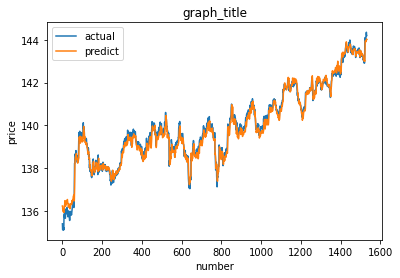

In [32]:

graph_title = '1h'
y_pred_1h, y_pred = learn(df, X_train, 'y_rate_1h', 'graph_title', epochs, './model/GBPJPY_1h/model.hdf5','./model/GBPJPY_1h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.4882 - mae: 0.3417 - val_loss: 0.1647 - val_mae: 0.4018

Epoch 00001: val_mae improved from inf to 0.40178, saving model to ./model/GBPJPY_2h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0369 - mae: 0.1542 - val_loss: 0.1365 - val_mae: 0.3665

Epoch 00002: val_mae improved from 0.40178 to 0.36648, saving model to ./model/GBPJPY_2h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0373 - mae: 0.1519 - val_loss: 0.1229 - val_mae: 0.3476

Epoch 00003: val_mae improved f

<Figure size 432x288 with 0 Axes>

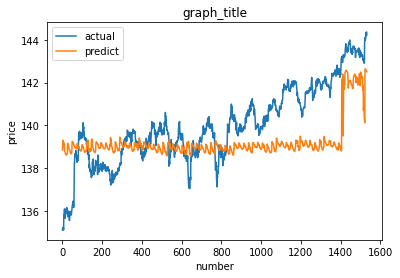

In [25]:

graph_title = '2h'
y_pred_2h, y_pred = learn(df, X_train, 'y_rate_2h', 'graph_title', epochs, './model/GBPJPY_2h/model.hdf5','./model/GBPJPY_2h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0530 - mae: 0.1787 - val_loss: 0.2597 - val_mae: 0.5073

Epoch 00001: val_mae improved from inf to 0.50733, saving model to ./model/GBPJPY_3h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0387 - mae: 0.1584 - val_loss: 0.1668 - val_mae: 0.4051

Epoch 00002: val_mae improved from 0.50733 to 0.40512, saving model to ./model/GBPJPY_3h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0371 - mae: 0.1531 - val_loss: 0.1770 - val_mae: 0.4178

Epoch 00003: val_mae did not im

<Figure size 432x288 with 0 Axes>

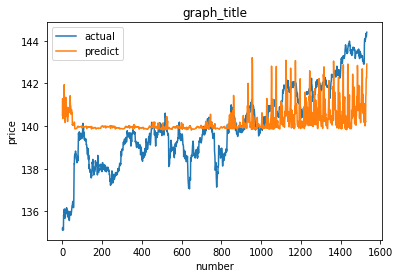

In [39]:

graph_title = '3h'
y_pred_3h, y_pred = learn(df, X_train, 'y_rate_3h', 'graph_title', epochs, './model/GBPJPY_3h/model.hdf5','./model/GBPJPY_3h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1304
列数: 18
整形前の形状(特徴量): (1304, 18)
形状(特徴量): (1304, 18, 1)
形状(目的変数): (1304, 1)
モデルの学習を開始します
Epoch 1/40
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0576 - mae: 0.1912 - val_loss: 0.1129 - val_mae: 0.3294

Epoch 00001: val_mae improved from inf to 0.32942, saving model to ./model/GBPJPY_4h\param.hdf5
Epoch 2/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0482 - mae: 0.1778 - val_loss: 0.2019 - val_mae: 0.4442

Epoch 00002: val_mae did not improve from 0.32942
Epoch 3/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0487 - mae: 0.1807 - val_loss: 0.1975 - val_mae: 0.4391

Epoch 00003: val_mae did not improve from 0.32942
Epoch 4/40
1264/1264 [=========

<Figure size 432x288 with 0 Axes>

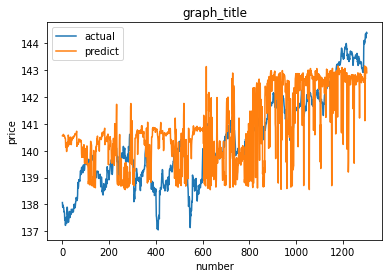

In [40]:

graph_title = '4h'
y_pred_4h, y_pred = learn(df, X_train, 'y_rate_4h', 'graph_title', epochs, './model/GBPJPY_4h/model.hdf5','./model/GBPJPY_4h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0558 - mae: 0.1827 - val_loss: 0.1800 - val_mae: 0.4210

Epoch 00001: val_mae improved from inf to 0.42104, saving model to ./model/GBPJPY_5h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0382 - mae: 0.1558 - val_loss: 0.1740 - val_mae: 0.4140

Epoch 00002: val_mae improved from 0.42104 to 0.41399, saving model to ./model/GBPJPY_5h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0383 - mae: 0.1546 - val_loss: 0.1587 - val_mae: 0.3951

Epoch 00003: val_mae improved f

<Figure size 432x288 with 0 Axes>

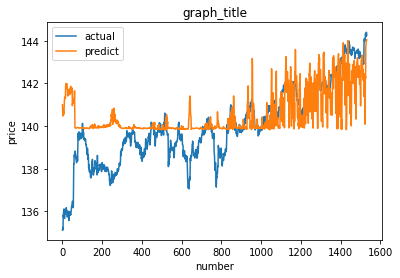

In [10]:

graph_title = '5h'
y_pred_5h, y_pred = learn(df, X_train, 'y_rate_5h', 'graph_title', epochs, './model/GBPJPY_5h/model.hdf5','./model/GBPJPY_5h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 7s 4ms/step - loss: 0.0513 - mae: 0.1731 - val_loss: 0.0844 - val_mae: 0.2863

Epoch 00001: val_mae improved from inf to 0.28632, saving model to ./model/GBPJPY_6h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 6s 4ms/step - loss: 0.0372 - mae: 0.1517 - val_loss: 0.1719 - val_mae: 0.4111

Epoch 00002: val_mae did not improve from 0.28632
Epoch 3/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0393 - mae: 0.1575 - val_loss: 0.1206 - val_mae: 0.3434

Epoch 00003: val_mae did not improve from 0.28632
Epoch 4/40
1486/1486 [=========

<Figure size 432x288 with 0 Axes>

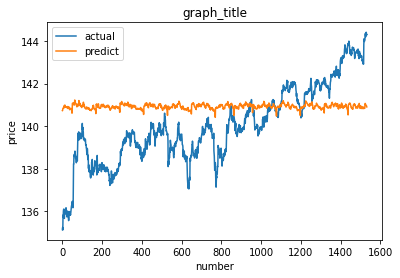

In [11]:

graph_title = '6h'
y_pred_6h, y_pred = learn(df, X_train, 'y_rate_6h', 'graph_title', epochs, './model/GBPJPY_6h/model.hdf5','./model/GBPJPY_6h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 6s 3ms/step - loss: 0.0569 - mae: 0.1781 - val_loss: 0.0295 - val_mae: 0.1652

Epoch 00001: val_mae improved from inf to 0.16523, saving model to ./model/GBPJPY_7h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0387 - mae: 0.1580 - val_loss: 0.2146 - val_mae: 0.4600

Epoch 00002: val_mae did not improve from 0.16523
Epoch 3/40
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0358 - mae: 0.1495 - val_loss: 0.1752 - val_mae: 0.4148

Epoch 00003: val_mae did not improve from 0.16523
Epoch 4/40
1486/1486 [=========

<Figure size 432x288 with 0 Axes>

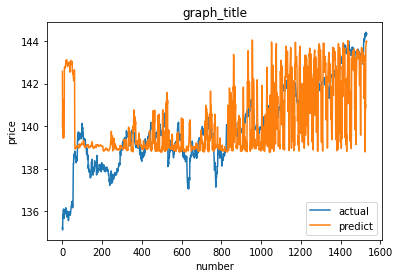

In [12]:

graph_title = '7h'
y_pred_7h, y_pred = learn(df, X_train, 'y_rate_7h', 'graph_title', epochs, './model/GBPJPY_7h/model.hdf5','./model/GBPJPY_7h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1304
列数: 18
整形前の形状(特徴量): (1304, 18)
形状(特徴量): (1304, 18, 1)
形状(目的変数): (1304, 1)
モデルの学習を開始します
Epoch 1/40
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0511 - mae: 0.1827 - val_loss: 0.2485 - val_mae: 0.4932

Epoch 00001: val_mae improved from inf to 0.49321, saving model to ./model/GBPJPY_8h\param.hdf5
Epoch 2/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0491 - mae: 0.1802 - val_loss: 0.2624 - val_mae: 0.5075

Epoch 00002: val_mae did not improve from 0.49321
Epoch 3/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0483 - mae: 0.1782 - val_loss: 0.2248 - val_mae: 0.4688

Epoch 00003: val_mae improved from 0.49321 to 0.46881, saving model to ./model/GB

<Figure size 432x288 with 0 Axes>

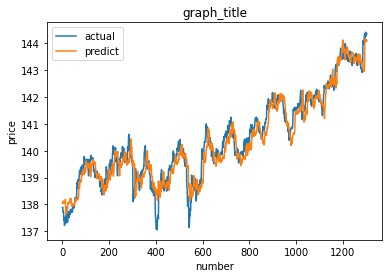

In [10]:

graph_title = '8h'
y_pred_8h, y_pred = learn(df, X_train, 'y_rate_8h', 'graph_title', epochs, './model/GBPJPY_8h/model.hdf5','./model/GBPJPY_8h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0467 - mae: 0.1697 - val_loss: 0.1449 - val_mae: 0.3746

Epoch 00001: val_mae improved from inf to 0.37456, saving model to ./model/GBPJPY_9h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0224 - mae: 0.1173 - val_loss: 0.0886 - val_mae: 0.2911

Epoch 00002: val_mae improved from 0.37456 to 0.29114, saving model to ./model/GBPJPY_9h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0174 - mae: 0.1054 - val_loss: 0.0570 - val_mae: 0.2290

Epoch 00003: val_mae improved f

<Figure size 432x288 with 0 Axes>

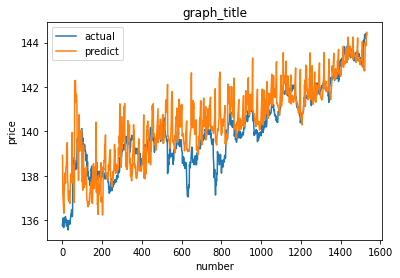

In [14]:

graph_title = '9h'
y_pred_9h, y_pred = learn(df, X_train, 'y_rate_9h', 'graph_title', epochs, './model/GBPJPY_9h/model.hdf5','./model/GBPJPY_9h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0501 - mae: 0.1731 - val_loss: 0.2035 - val_mae: 0.4467

Epoch 00001: val_mae improved from inf to 0.44667, saving model to ./model/GBPJPY_10h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0424 - mae: 0.1649 - val_loss: 0.1572 - val_mae: 0.3916

Epoch 00002: val_mae improved from 0.44667 to 0.39158, saving model to ./model/GBPJPY_10h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0391 - mae: 0.1564 - val_loss: 0.2288 - val_mae: 0.4733

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

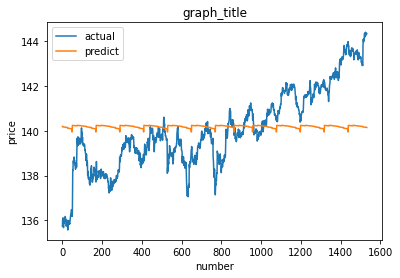

In [15]:

graph_title = '10h'
y_pred_10h, y_pred = learn(df, X_train, 'y_rate_10h', 'graph_title', epochs, './model/GBPJPY_10h/model.hdf5','./model/GBPJPY_10h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0462 - mae: 0.1701 - val_loss: 0.0654 - val_mae: 0.2492

Epoch 00001: val_mae improved from inf to 0.24922, saving model to ./model/GBPJPY_11h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0414 - mae: 0.1613 - val_loss: 0.0838 - val_mae: 0.2828

Epoch 00002: val_mae did not improve from 0.24922
Epoch 3/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0391 - mae: 0.1583 - val_loss: 0.1730 - val_mae: 0.4108

Epoch 00003: val_mae did not improve from 0.24922
Epoch 4/40
1486/1486 [========

<Figure size 432x288 with 0 Axes>

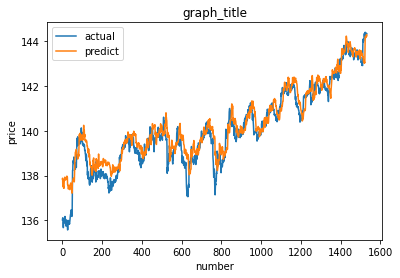

In [16]:

graph_title = '11h'
y_pred_11h, y_pred = learn(df, X_train, 'y_rate_11h', 'graph_title', epochs, './model/GBPJPY_11h/model.hdf5','./model/GBPJPY_11h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1304
列数: 18
整形前の形状(特徴量): (1304, 18)
形状(特徴量): (1304, 18, 1)
形状(目的変数): (1304, 1)
モデルの学習を開始します
Epoch 1/40
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0610 - mae: 0.1982 - val_loss: 0.2445 - val_mae: 0.4877

Epoch 00001: val_mae improved from inf to 0.48766, saving model to ./model/GBPJPY_12h\param.hdf5
Epoch 2/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0464 - mae: 0.1752 - val_loss: 0.2486 - val_mae: 0.4922

Epoch 00002: val_mae did not improve from 0.48766
Epoch 3/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0482 - mae: 0.1802 - val_loss: 0.2275 - val_mae: 0.4707

Epoch 00003: val_mae improved from 0.48766 to 0.47072, saving model to ./model/G

<Figure size 432x288 with 0 Axes>

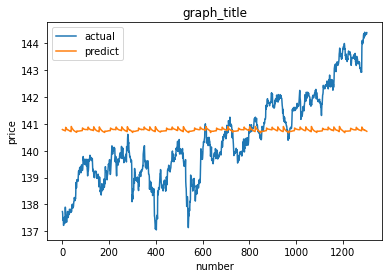

In [16]:

graph_title = '12h'
y_pred_12h, y_pred = learn(df, X_train, 'y_rate_12h', 'graph_title', epochs, './model/GBPJPY_12h/model.hdf5','./model/GBPJPY_12h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0501 - mae: 0.1815 - val_loss: 0.1439 - val_mae: 0.3737

Epoch 00001: val_mae improved from inf to 0.37367, saving model to ./model/GBPJPY_13h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0395 - mae: 0.1570 - val_loss: 0.2049 - val_mae: 0.4477

Epoch 00002: val_mae did not improve from 0.37367
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0396 - mae: 0.1597 - val_loss: 0.1890 - val_mae: 0.4293

Epoch 00003: val_mae did not improve from 0.37367
Epoch 4/40
1486/1486 [========

<Figure size 432x288 with 0 Axes>

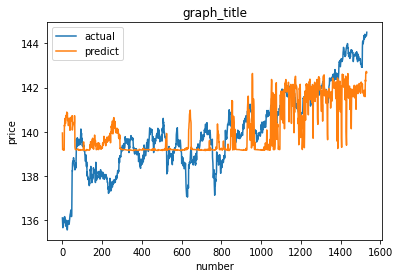

In [48]:

graph_title = '13h'
y_pred_13h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_13h/model.hdf5','./model/GBPJPY_13h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0525 - mae: 0.1779 - val_loss: 0.2248 - val_mae: 0.4699

Epoch 00001: val_mae improved from inf to 0.46992, saving model to ./model/GBPJPY_14h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0416 - mae: 0.1629 - val_loss: 0.2735 - val_mae: 0.5185

Epoch 00002: val_mae did not improve from 0.46992
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0389 - mae: 0.1563 - val_loss: 0.2379 - val_mae: 0.4831

Epoch 00003: val_mae did not improve from 0.46992
Epoch 4/40
1486/1486 [========

<Figure size 432x288 with 0 Axes>

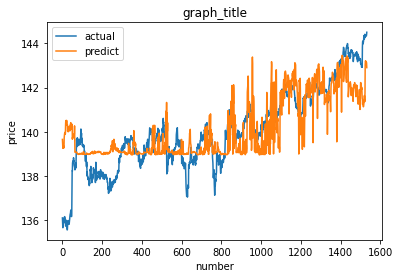

In [49]:

graph_title = '14h'
y_pred_14h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_14h/model.hdf5','./model/GBPJPY_14h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 4s 2ms/step - loss: 0.2946 - mae: 0.3308 - val_loss: 0.1626 - val_mae: 0.3979

Epoch 00001: val_mae improved from inf to 0.39788, saving model to ./model/GBPJPY_15h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0341 - mae: 0.1486 - val_loss: 0.1613 - val_mae: 0.3962

Epoch 00002: val_mae improved from 0.39788 to 0.39615, saving model to ./model/GBPJPY_15h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 3s 2ms/step - loss: 0.0372 - mae: 0.1537 - val_loss: 0.1384 - val_mae: 0.3669

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

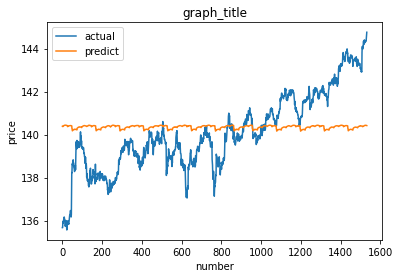

In [50]:

graph_title = '15h'
y_pred_15h, y_pred = learn(df, X_train, 'y_rate_15h', 'graph_title', epochs, './model/GBPJPY_15h/model.hdf5','./model/GBPJPY_15h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0502 - mae: 0.1723 - val_loss: 0.4016 - val_mae: 0.6316

Epoch 00001: val_mae improved from inf to 0.63162, saving model to ./model/GBPJPY_16h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0439 - mae: 0.1658 - val_loss: 0.2518 - val_mae: 0.4972

Epoch 00002: val_mae improved from 0.63162 to 0.49718, saving model to ./model/GBPJPY_16h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0362 - mae: 0.1522 - val_loss: 0.1601 - val_mae: 0.3944

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

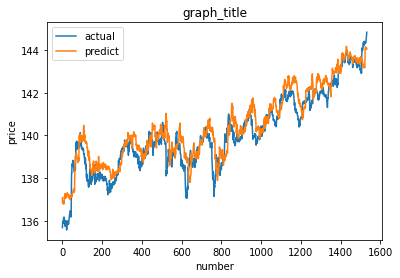

In [51]:

graph_title = '16h'
y_pred_16h, y_pred = learn(df, X_train, 'y_rate_16h', 'graph_title', epochs, './model/GBPJPY_16h/model.hdf5','./model/GBPJPY_16h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0540 - mae: 0.1803 - val_loss: 0.2289 - val_mae: 0.4739

Epoch 00001: val_mae improved from inf to 0.47389, saving model to ./model/GBPJPY_17h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0361 - mae: 0.1512 - val_loss: 0.1475 - val_mae: 0.3783

Epoch 00002: val_mae improved from 0.47389 to 0.37827, saving model to ./model/GBPJPY_17h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0348 - mae: 0.1486 - val_loss: 0.1922 - val_mae: 0.4330

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

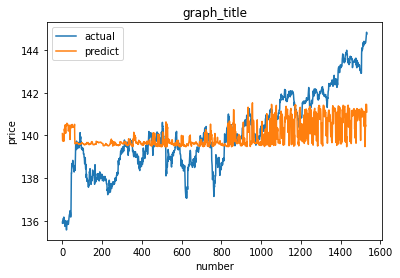

In [52]:

graph_title = '17h'
y_pred_17h, y_pred = learn(df, X_train, 'y_rate_17h', 'graph_title', epochs, './model/GBPJPY_17h/model.hdf5','./model/GBPJPY_17h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 6s 3ms/step - loss: 0.0507 - mae: 0.1741 - val_loss: 0.1745 - val_mae: 0.4120

Epoch 00001: val_mae improved from inf to 0.41197, saving model to ./model/GBPJPY_18h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0384 - mae: 0.1589 - val_loss: 0.1737 - val_mae: 0.4107

Epoch 00002: val_mae improved from 0.41197 to 0.41071, saving model to ./model/GBPJPY_18h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0359 - mae: 0.1521 - val_loss: 0.1940 - val_mae: 0.4344

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

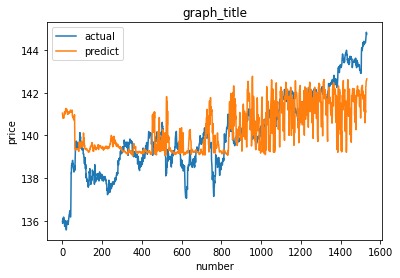

In [53]:

graph_title = '18h'
y_pred_18h, y_pred = learn(df, X_train, 'y_rate_18h', 'graph_title', epochs, './model/GBPJPY_18h/model.hdf5','./model/GBPJPY_18h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 6s 3ms/step - loss: 0.0319 - mae: 0.1395 - val_loss: 0.0731 - val_mae: 0.2596

Epoch 00001: val_mae improved from inf to 0.25960, saving model to ./model/GBPJPY_19h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0158 - mae: 0.0994 - val_loss: 0.1550 - val_mae: 0.3858

Epoch 00002: val_mae did not improve from 0.25960
Epoch 3/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0163 - mae: 0.1004 - val_loss: 0.0191 - val_mae: 0.1229

Epoch 00003: val_mae improved from 0.25960 to 0.12290, saving model to ./model/G

<Figure size 432x288 with 0 Axes>

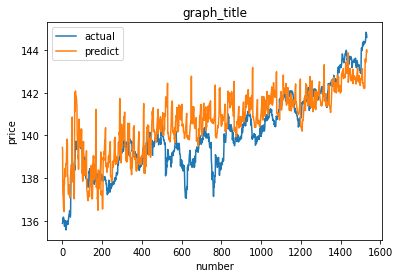

In [54]:

graph_title = '19h'
y_pred_19h, y_pred = learn(df, X_train, 'y_rate_19h', 'graph_title', epochs, './model/GBPJPY_19h/model.hdf5','./model/GBPJPY_19h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1304
列数: 18
整形前の形状(特徴量): (1304, 18)
形状(特徴量): (1304, 18, 1)
形状(目的変数): (1304, 1)
モデルの学習を開始します
Epoch 1/40
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0629 - mae: 0.1857 - val_loss: 0.2797 - val_mae: 0.5213

Epoch 00001: val_mae improved from inf to 0.52132, saving model to ./model/GBPJPY_20h\param.hdf5
Epoch 2/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0433 - mae: 0.1690 - val_loss: 0.2217 - val_mae: 0.4640

Epoch 00002: val_mae improved from 0.52132 to 0.46398, saving model to ./model/GBPJPY_20h\param.hdf5
Epoch 3/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0439 - mae: 0.1718 - val_loss: 0.2103 - val_mae: 0.4519

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

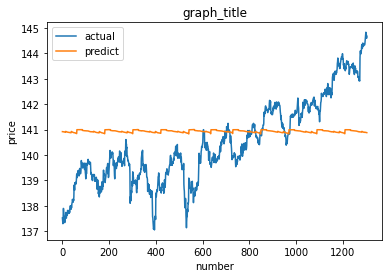

In [22]:

graph_title = '20h'
y_pred_20h, y_pred = learn(df, X_train, 'y_rate_20h', 'graph_title', epochs, './model/GBPJPY_20h/model.hdf5','./model/GBPJPY_20h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0495 - mae: 0.1717 - val_loss: 0.2237 - val_mae: 0.4673

Epoch 00001: val_mae improved from inf to 0.46732, saving model to ./model/GBPJPY_21h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0371 - mae: 0.1554 - val_loss: 0.1558 - val_mae: 0.3886

Epoch 00002: val_mae improved from 0.46732 to 0.38861, saving model to ./model/GBPJPY_21h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0378 - mae: 0.1582 - val_loss: 0.2552 - val_mae: 0.5004

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

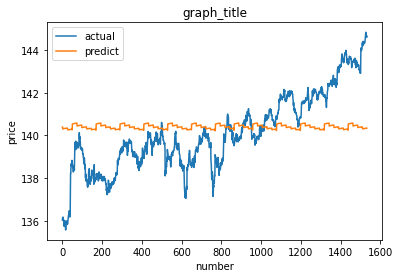

In [56]:

graph_title = '21h'
y_pred_21h, y_pred = learn(df, X_train, 'y_rate_21h', 'graph_title', epochs, './model/GBPJPY_21h/model.hdf5','./model/GBPJPY_21h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 6s 3ms/step - loss: 0.0472 - mae: 0.1675 - val_loss: 0.2872 - val_mae: 0.5311

Epoch 00001: val_mae improved from inf to 0.53114, saving model to ./model/GBPJPY_22h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 5s 3ms/step - loss: 0.0370 - mae: 0.1558 - val_loss: 0.2428 - val_mae: 0.4876

Epoch 00002: val_mae improved from 0.53114 to 0.48757, saving model to ./model/GBPJPY_22h\param.hdf5
Epoch 3/40
1486/1486 [==============================] - 6s 4ms/step - loss: 0.0356 - mae: 0.1530 - val_loss: 0.2129 - val_mae: 0.4560

Epoch 00003: val_mae improved

<Figure size 432x288 with 0 Axes>

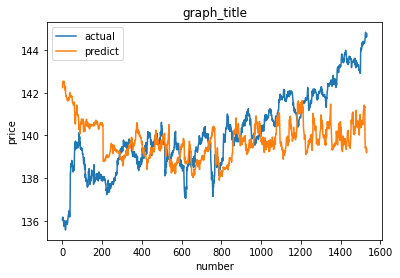

In [57]:

graph_title = '22h'
y_pred_22h, y_pred = learn(df, X_train, 'y_rate_22h', 'graph_title', epochs, './model/GBPJPY_22h/model.hdf5','./model/GBPJPY_22h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1532
列数: 18
整形前の形状(特徴量): (1532, 18)
形状(特徴量): (1532, 18, 1)
形状(目的変数): (1532, 1)
モデルの学習を開始します
Epoch 1/40
1486/1486 [==============================] - 7s 4ms/step - loss: 0.0633 - mae: 0.1792 - val_loss: 0.1504 - val_mae: 0.3818

Epoch 00001: val_mae improved from inf to 0.38181, saving model to ./model/GBPJPY_23h\param.hdf5
Epoch 2/40
1486/1486 [==============================] - 6s 4ms/step - loss: 0.0393 - mae: 0.1611 - val_loss: 0.2041 - val_mae: 0.4464

Epoch 00002: val_mae did not improve from 0.38181
Epoch 3/40
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0352 - mae: 0.1498 - val_loss: 0.1955 - val_mae: 0.4359

Epoch 00003: val_mae did not improve from 0.38181
Epoch 4/40
1486/1486 [========

<Figure size 432x288 with 0 Axes>

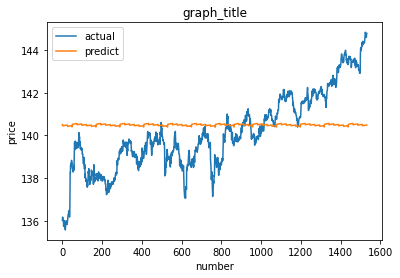

In [58]:

graph_title = '23h'
y_pred_23h, y_pred = learn(df, X_train, 'y_rate_23h', 'graph_title', epochs, './model/GBPJPY_23h/model.hdf5','./model/GBPJPY_23h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1304
列数: 18
整形前の形状(特徴量): (1304, 18)
形状(特徴量): (1304, 18, 1)
形状(目的変数): (1304, 1)
モデルの学習を開始します
Epoch 1/40
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0490 - mae: 0.1820 - val_loss: 0.2656 - val_mae: 0.5102

Epoch 00001: val_mae improved from inf to 0.51019, saving model to ./model/GBPJPY_24h\param.hdf5
Epoch 2/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0430 - mae: 0.1698 - val_loss: 0.2239 - val_mae: 0.4670

Epoch 00002: val_mae improved from 0.51019 to 0.46698, saving model to ./model/GBPJPY_24h\param.hdf5
Epoch 3/40
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0426 - mae: 0.1718 - val_loss: 0.2495 - val_mae: 0.4935

Epoch 00003: val_mae did not 

<Figure size 432x288 with 0 Axes>

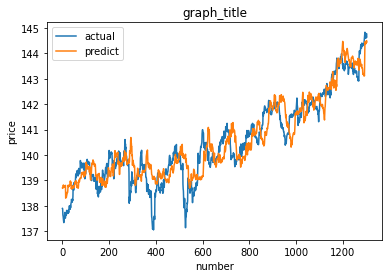

In [63]:

graph_title = '24h'
y_pred_24h, y_pred = learn(df, X_train, 'y_rate_24h', 'graph_title', epochs, './model/GBPJPY_24h/model.hdf5','./model/GBPJPY_24h/param.hdf5') # 学習関数


In [ ]:
plot_list = np.concatenate([y_pred_1h, y_pred_2h, y_pred_3h, y_pred_4h, y_pred_5h, y_pred_6h, y_pred_7h, y_pred_8h
                           , y_pred_9h, y_pred_10h, y_pred_11h, y_pred_12h, y_pred_13h, y_pred_14h, y_pred_15h, y_pred_16h
                           , y_pred_17h, y_pred_18h, y_pred_19h, y_pred_20h, y_pred_21h, y_pred_22h, y_pred_23h, y_pred_24h])# 5m, 1h, 4h, 8h, 1dの予測リスト

def plot_pred(plot_list):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title='title')  # グラフ作成
    
    ax.plot(plot_list, label='actual')  # 5m, 1h, 4h, 8h, 1dの予測リスト
   # ax.plot(y_pred, label='predict')  # 予測
    plt.legend()

plot_pred(plot_list)
print(plot_list)

In [ ]:
a = df['y_rate_2h'].tolist() # Tolistを使う予定

y = a - y_pred


In [ ]:
print(len(a))
print(len(y_pred))
print(len(y))


In [ ]:
#tensorboard --logdir='./logs'